const       float64
Assault       int64
UrbanPop      int64
Murder      float64
dtype: object

Descriptive Statistics:


,Assault,UrbanPop,Murder
count,50.000000,50.000000,50.00000
mean,170.760000,65.540000,7.78800
std,83.337661,14.474763,4.35551
min,45.000000,32.000000,0.80000
25%,109.000000,54.500000,4.07500
50%,159.000000,66.000000,7.25000
75%,249.000000,77.750000,11.25000
max,337.000000,91.000000,17.40000


Correlation matrix of the predictors:


,Assault,UrbanPop,Murder
Assault,1.000000,0.258872,0.801873
UrbanPop,0.258872,1.000000,0.069573
Murder,0.801873,0.069573,1.000000


Correlations between predictors > 0.6?:


,Assault,UrbanPop,Murder
Assault,True,False,True
UrbanPop,False,True,False
Murder,True,False,True


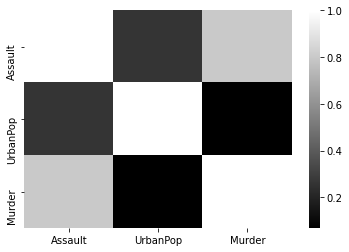

There is not evidence of multicolinearity.


<Figure size 432x288 with 0 Axes>

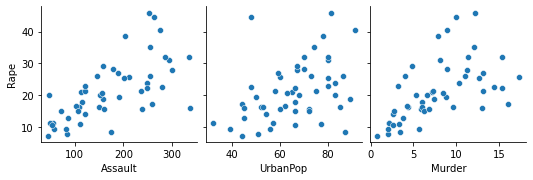

There are no extreme outliers.

The predictors met the requirements for linear regression.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.stats

# importing and subsetting the data

# data obtained from 'https://forge.scilab.org/index.php/p/rdataset/source/tree/master/csv/datasets/USArrests.csv'

# documentation for data: 'https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests'

df = pd.read_csv('USArrests.csv')

df.rename(columns = {'Unnamed: 0':'State'}, inplace = True) 


outcome = df['Rape'].copy()

predictors = df[['Assault', 'UrbanPop', 'Murder']].copy()

predictors = sm.add_constant(predictors) 

# checking the data types of the predictors (to look for nans etc)
print(predictors.dtypes)

# getting an array of the predictor names
not_intercept = predictors.columns[predictors.columns != 'const']

# plotting the descriptive statistics for each predictor
print('\nDescriptive Statistics:')
display(predictors[not_intercept].describe())

# checking for colinearity (before checking for multicolinearity)

# setting a cutoff for what will be considered extreme colinearity
cutoff = 0.6

corr_mat = predictors[not_intercept].corr()
print('Correlation matrix of the predictors:')
display(corr_mat)
print('Correlations between predictors > '+str(cutoff)+'?:')
display(corr_mat > cutoff)

# plotting a heatmap of the correlations between the predictors

plt.figure()
sns.heatmap(corr_mat, cmap = 'gray')
plt.show()

# counting the number of bivariate correlations between the predictors > the cutoff 
num_correlated_predictors = np.count_nonzero(corr_mat > cutoff) - 3 # subtracting out the diagonal

lin_reg_checks = {'colinearity': 'pass/fail',
                 'outliers': 'pass/fail'}

if num_correlated_predictors > 2:
    print('Several of the predictors have bivariate correlations >'+str(cutoff)+'. Check for multicolinearity. ')
    lin_reg_checks['colinearity'] = 'fail'
else:
    print('There is not evidence of multicolinearity.')
    lin_reg_checks['colinearity'] = 'pass'
    
# looking for outliers with a pairplot

plt.figure()
sns.pairplot(data = df, x_vars = not_intercept, y_vars = 'Rape')
plt.show()

# checking for extreme outliers (+ or - 3 sd from the mean of the predictor)

prop_outliers_array = np.array([])
for i in not_intercept:
    pred_mean = np.mean(predictors[i])
    pred_sd = np.std(predictors[i], ddof = 1)
    prop_outliers = np.count_nonzero(np.abs(predictors[i]) > pred_mean + 3 * pred_sd)/len(predictors[i])
    prop_outliers_array = np.append(prop_outliers_array, prop_outliers)
    
if np.count_nonzero(prop_outliers_array > 0) > 0:
    print('There are extreme outliers, check the "prop_outliers_array" and the corresponding element of "predictors[not_intercept].columns".')
    lin_reg_checks['outliers'] = 'fail'
else:
    print('There are no extreme outliers.')
    lin_reg_checks['outliers'] = 'pass'
    
if np.count_nonzero(np.array([list(lin_reg_checks.values())]) == 'fail') == 0:
    print('\nThe predictors met the requirements for linear regression.')
else: 
    print('\nThe predictors did not meet the requirements for linear regression. Check the outputs above.')

In [2]:
mod = sm.OLS(outcome, predictors).fit()

print_mod = mod.summary()
print(print_mod)

# writing a function to check that the assumptions of linear regression regarding the distribution of residuals are met
# e.g. normality, independence of errors and homogeneity of variance

def lin_reg_res_checker(residuals, predictor_vars):
    norm_test = scipy.stats.normaltest(residuals)
    autocorr_test = sm.stats.stattools.durbin_watson(residuals)
    homosced_test = sm.stats.diagnostic.het_breuschpagan(residuals, predictor_vars)

    print()
    if norm_test.pvalue > 0.05:
        print('The Omnibus test indicates that the residuals are normally distributed.')
    elif norm_test.pvalue <= 0.05:
        print('The Omnibus test indicates that the residuals are NOT normally distributed.')

    if autocorr_test > 1.5  and autocorr_test < 2.5 : # https://www.statisticshowto.com/durbin-watson-test-coefficient/
        print('The Durbin-Watson test indicates that the residuals are not autocorrelated.')
    elif autocorr_test <= 1.5 or autocorr_test >= 2.5:
        print('The Durbin-Watson test indicates that the residuals ARE autocorrelated.')

    if homosced_test[1] > 0.05 and homosced_test[-1] > 0.05:
        print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are homoscedastic.')

    elif homosced_test[1] <= 0.05 or homosced_test[-1] <=  0.05:
        print('The Breusch-Pagan Lagrange Multiplier test indicates that the residuals are HETEROscedastic')

    if norm_test.pvalue > 0.05 and autocorr_test > 1.5 and autocorr_test < 2.5 and homosced_test[1] > 0.05 and homosced_test[-1] > 0.05:
        print('\nThe tests on the residuals show that the assumptions of linear regression were met.')
    else:
        print('\nSome of the assumptions of linear regression regarding the distribution of residuals were not met. See the specific test printouts above.')
        
lin_reg_res_checker(mod.resid, predictors)

                            OLS Regression Results                            
Dep. Variable:                   Rape   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     16.39
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           2.21e-07
Time:                        17:18:53   Log-Likelihood:                -164.13
No. Observations:                  50   AIC:                             336.3
Df Residuals:                      46   BIC:                             343.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4741      4.696     -0.527      0.6

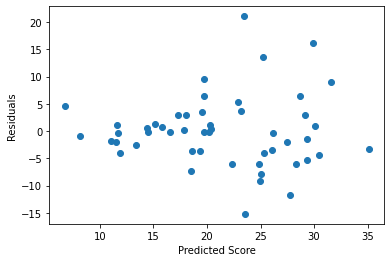

In [3]:
# plotting the residuals against the predicted values, to inspect the heteroscedasticity
plt.scatter(mod.predict(predictors), mod.resid)
plt.ylabel('Residuals')
plt.xlabel('Predicted Score')
plt.show()

                            OLS Regression Results                            
Dep. Variable:               log_rape   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     21.56
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           7.25e-09
Time:                        17:18:54   Log-Likelihood:                -8.8327
No. Observations:                  50   AIC:                             25.67
Df Residuals:                      46   BIC:                             33.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7050      0.210      8.108      0.0

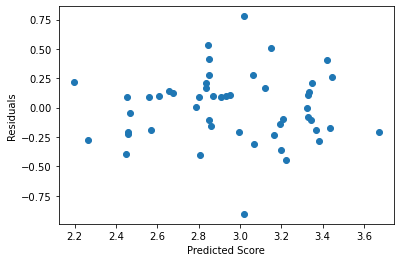

In [4]:
# log transforming the dependent variable, to account for heteroscedascity of the residuals
# see: https://blog.usejournal.com/linear-regression-heteroskedasticity-myths-of-transformations-d27dc00db6ea

log_outcome = pd.DataFrame()
log_outcome['log_rape'] = np.log(outcome).copy()

mod_2 = sm.OLS(log_outcome, predictors).fit()

print_mod_2 = mod_2.summary()
print(print_mod_2)

lin_reg_res_checker(mod_2.resid, predictors)

# plotting the residuals against the predicted values from the model with the log transformed outcome, 
# to inspect the heteroscedasticity
plt.scatter(mod_2.predict(predictors), mod_2.resid)
plt.ylabel('Residuals')
plt.xlabel('Predicted Score')
plt.show()

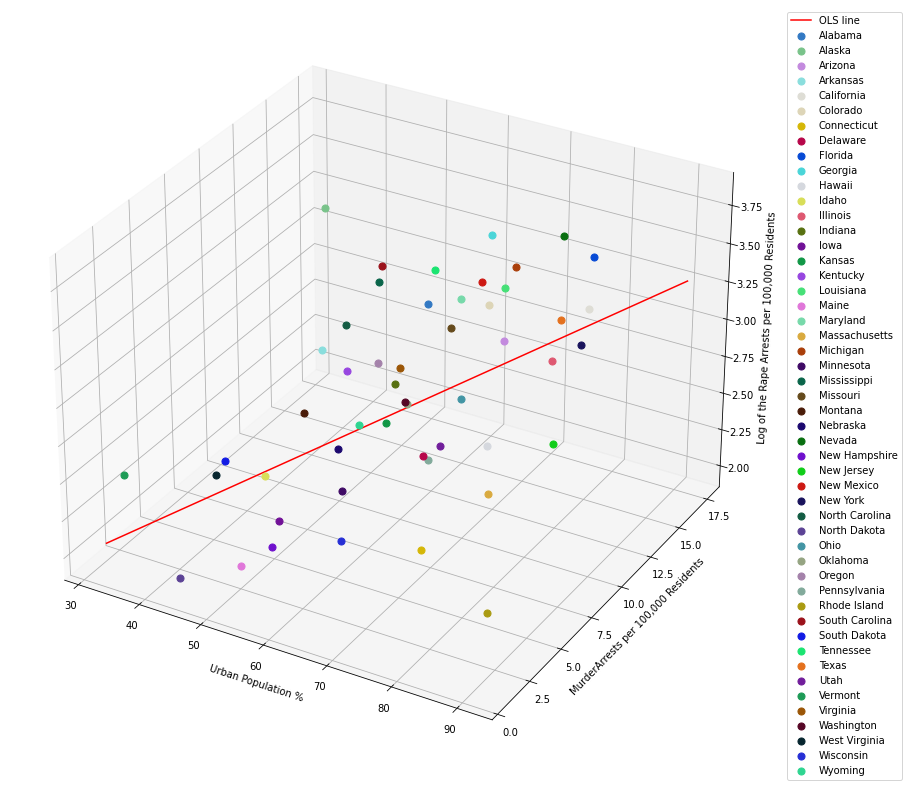

In [5]:
# the second model with the log transformed outcome variable had a better adjusted r^2, better AIC and BIC

# calculating a regression line from the significant predictors

b0 = mod_2.params[0]
b1 = mod_2.params[2]
b2 = mod_2.params[3]
x1_assault = np.linspace(min(predictors['UrbanPop']), max(predictors['UrbanPop']))
x2_murder = np.linspace(min(predictors['Murder']), max(predictors['Murder']))
y_hat = b0 + b1*x1_assault + b2*x2_murder

# plotting the data and the regression line

fig = plt.figure(3,figsize = (18,14))
ax = fig.add_subplot(111, projection='3d')

# creating a colourmap to color each datapoint
zero_1 = np.random.uniform(0,1, size = 100000)
cmap = np.random.choice(zero_1, replace = False, size = len(df)+2)

for i in range(len(df)):
    ax.scatter(df['UrbanPop'][i], df['Murder'][i], np.log(df['Rape'][i]),  label = df['State'][i],
               color = [cmap[i], cmap[i+1], cmap[i+2]], s =50)
    
ax.plot(x1_assault, x2_murder, y_hat, color = 'red', label = 'OLS line')
plt.xlabel('Urban Population %')
plt.ylabel('MurderArrests per 100,000 Residents')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
ax.set_zlabel('Log of the Rape Arrests per 100,000 Residents')
plt.show()